In [47]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
SEED = 42
BATCH_SIZE = 256
EPOCHS = 10
LR = 1e-3

In [3]:
WINDOW_IN_MIN = 180   # 3 hours window for input
WINDOW_OUT_MIN = 60   # 1 hour ahead for output

flare_order = {"A": 0, "B": 1, "C": 2, "M": 3, "X": 4}

def get_highest_class(classes):
    if len(classes) == 0:
        return "A"
    return max(classes, key=lambda c: flare_order[c])

def make_future_labels(index, flare_df, horizon_min=60):

    # DatetimeIndex of the 1-min irradiance series
    # flare_df: dataframe with ['flare_time', 'class_letter']

    fl_times = flare_df['flare_time'].values
    fl_classes = flare_df['class_letter'].values
    n_events = len(fl_times)

    labels = []
    j = 0

    for t in index.values:
        # advance pointer past any flares before t
        while j < n_events and fl_times[j] < t:
            j += 1

        h_end = t + np.timedelta64(horizon_min, 'm')
        k = j
        classes = []

        while k < n_events and fl_times[k] <= h_end:
            classes.append(fl_classes[k])
            k += 1

        labels.append(get_highest_class(classes))

    return np.array(labels)

def build_windows(irrad_1m, labels, window_in_min=180):
    data = irrad_1m[['short_xray', 'long_xray']].values
    X_list, y_list = [], []

    for i in range(window_in_min, len(irrad_1m)):
        x_window = data[i-window_in_min:i, :]
        X_list.append(x_window)
        y_list.append(labels[i])

    X = np.stack(X_list)
    y = np.array(y_list)
    return X, y


In [4]:
def process_year(year, base_irrad_dir="", base_flsum_dir=""):
    print(f"\n=== Processing year {year} ===")
    irrad_path = f"{base_irrad_dir}irrad_{year}.nc"
    flsum_path = f"{base_flsum_dir}flsum_{year}.nc"

    # 1) Load irrad
    irrad_ds = xr.open_dataset(irrad_path)
    irrad_df = irrad_ds[['a_flux', 'b_flux']].to_dataframe().reset_index()

    irrad_df.rename(columns={
        'time': 'timestamp',
        'a_flux': 'short_xray',
        'b_flux': 'long_xray'
    }, inplace=True)

    irrad_df['timestamp'] = pd.to_datetime(irrad_df['timestamp'])
    irrad_df.set_index('timestamp', inplace=True)

    # 2) Resample to 1-min
    irrad_1m = irrad_df.resample('1min').mean().dropna()
    print("1-min irradiance shape:", irrad_1m.shape)

    # 3) Load flare summary
    flsum_ds = xr.open_dataset(flsum_path)
    flsum_df = flsum_ds[['flare_class']].to_dataframe().reset_index()

    flsum_df.rename(columns={'time': 'flare_time'}, inplace=True)
    flsum_df['flare_time'] = pd.to_datetime(flsum_df['flare_time'])
    flsum_df['class_letter'] = flsum_df['flare_class'].astype(str).str[0]

    valid_classes = ['A', 'B', 'C', 'M', 'X']
    flsum_df = flsum_df[flsum_df['class_letter'].isin(valid_classes)].copy()
    flsum_df.sort_values('flare_time', inplace=True)
    flsum_df.reset_index(drop=True, inplace=True)

    print("Number of flare events:", len(flsum_df))

    # 4) Future labels (next 1 hour)
    labels = make_future_labels(irrad_1m.index, flsum_df, horizon_min=WINDOW_OUT_MIN)
    print("Labels shape:", labels.shape)

    # 5) Build sliding windows
    X_year, y_year = build_windows(irrad_1m, labels, window_in_min=WINDOW_IN_MIN)
    print("Year", year, "X shape:", X_year.shape, "y shape:", y_year.shape)

    return X_year, y_year

In [5]:
base_irrad_dir = "C:/Users/ruthw/Desktop/irrad/"
base_flsum_dir = "C:/Users/ruthw/Desktop/flsum/"

In [16]:
YEARS = [2015, 2016, 2017]  # adjust to what you have

X_list = []
y_list = []

for year in YEARS:
    X_y, y_y = process_year(year, base_irrad_dir, base_flsum_dir)
    X_list.append(X_y)
    y_list.append(y_y)

X_all = np.concatenate(X_list, axis=0)
y_all = np.concatenate(y_list, axis=0)

print("Combined X:", X_all.shape)
print("Combined y:", y_all.shape)
print(pd.Series(y_all).value_counts())


=== Processing year 2015 ===
1-min irradiance shape: (498420, 2)
Number of flare events: 2822
Labels shape: (498420,)
Year 2015 X shape: (498240, 180, 2) y shape: (498240,)

=== Processing year 2016 ===
1-min irradiance shape: (501754, 2)
Number of flare events: 2084
Labels shape: (501754,)
Year 2016 X shape: (501574, 180, 2) y shape: (501574,)

=== Processing year 2017 ===
1-min irradiance shape: (497854, 2)
Number of flare events: 1541
Labels shape: (497854,)
Year 2017 X shape: (497674, 180, 2) y shape: (497674,)
Combined X: (1497488, 180, 2)
Combined y: (1497488,)
A    1182164
B     160989
C     138797
M      14842
X        696
Name: count, dtype: int64


In [17]:
# Clean
X_all[~np.isfinite(X_all)] = 0.0
X_all = np.clip(X_all, 0.0, None)

# Log-transform
X_all = np.log10(X_all + 1e-10)

# Optional: global standardization
mean = X_all.mean(axis=(0, 1), keepdims=True)
std  = X_all.std(axis=(0, 1), keepdims=True) + 1e-6
X_all = (X_all - mean) / std

print("After transform, any NaN?", np.isnan(X_all).any(), " any Inf?", np.isinf(X_all).any())

After transform, any NaN? False  any Inf? False


In [18]:
np.save("X_multi.npy", X_all)
np.save("y_multi.npy", y_all)

In [19]:
X = np.load("X_multi.npy")
y = np.load("y_multi.npy")

# Manual encoding to keep class order fixed
label_map = {'A': 0, 'B': 1, 'C': 2, 'M': 3, 'X': 4}
y_encoded = np.array([label_map[c] for c in y])
inv_label_map = {v: k for k, v in label_map.items()}

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.30, random_state=42, stratify=y_encoded
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

classes = np.array([0,1,2,3,4])
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
class_weights = torch.tensor(class_weights, dtype=torch.float32)
print("Class weights:", class_weights)

Class weights: tensor([2.5335e-01, 1.8604e+00, 2.1578e+00, 2.0178e+01, 4.3049e+02])


# MODELS

In [20]:
print("X:", X.shape)
print("y:", y.shape)
pd.Series(y).value_counts()

X: (1497488, 180, 2)
y: (1497488,)


A    1182164
B     160989
C     138797
M      14842
X        696
Name: count, dtype: int64

In [21]:
label_map = {'A': 0, 'B': 1, 'C': 2, 'M': 3, 'X': 4}
inv_label_map = {v: k for k, v in label_map.items()}

y_encoded = np.array([label_map[c] for c in y])

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.30, random_state=42, stratify=y_encoded
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train: (1048241, 180, 2) Val: (224623, 180, 2) Test: (224624, 180, 2)


In [23]:
classes = np.array([0,1,2,3,4])

raw_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)

# Tame extreme imbalance
scaled_weights = np.sqrt(raw_weights)
scaled_weights = scaled_weights / scaled_weights.min()

class_weights = torch.tensor(scaled_weights, dtype=torch.float32)

print("Raw:", raw_weights)
print("Scaled:", scaled_weights)

Raw: [2.53347013e-01 1.86036453e+00 2.15780687e+00 2.01778826e+01
 4.30489117e+02]
Scaled: [ 1.          2.70982429  2.91842402  8.92441795 41.22144335]


In [24]:
class GOESDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # (180, 2) → (2, 180)
        x = self.X[idx].transpose(1, 0)
        return x, self.y[idx]

train_loader = DataLoader(GOESDataset(X_train, y_train), batch_size=256, shuffle=True)
val_loader   = DataLoader(GOESDataset(X_val, y_val), batch_size=512, shuffle=False)
test_loader  = DataLoader(GOESDataset(X_test, y_test), batch_size=512, shuffle=False)

In [25]:
# CNN

In [26]:
class CNN1D(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Conv1d(2, 32, kernel_size=5, padding=2)
        self.bn1   = nn.BatchNorm1d(32)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2   = nn.BatchNorm1d(64)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.bn3   = nn.BatchNorm1d(128)

        self.pool = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(0.3)

        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(128, n_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.global_pool(x).squeeze(-1)
        x = self.dropout(x)
        return self.fc(x)

In [27]:
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=1.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, logits, targets):
        ce = F.cross_entropy(logits, targets, weight=self.alpha, reduction='none')
        pt = torch.exp(-ce)
        loss = ((1 - pt) ** self.gamma) * ce
        return loss.mean()

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN1D(n_classes=5).to(device)
criterion = FocalLoss(alpha=class_weights.to(device), gamma=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def run_epoch(loader, train=True):
    if train:
        model.train()
    else:
        model.eval()

    total_loss, correct, total = 0, 0, 0

    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)
        if train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            out = model(Xb)
            loss = criterion(out, yb)
            if train:
                loss.backward()
                optimizer.step()

        total_loss += loss.item() * len(yb)
        preds = out.argmax(1)
        correct += (preds == yb).sum().item()
        total += len(yb)

    return total_loss / total, correct / total

In [31]:
for ep in range(1, EPOCHS+1):
    train_loss, train_acc = run_epoch(train_loader, train=True)
    val_loss, val_acc     = run_epoch(val_loader, train=False)

    print(f"Epoch {ep:02d} | "
          f"Train loss {train_loss:.4f}, acc {train_acc:.3f} | "
          f"Val loss {val_loss:.4f}, acc {val_acc:.3f}")

Epoch 01 | Train loss 1.0127, acc 0.689 | Val loss 1.0137, acc 0.545
Epoch 02 | Train loss 0.9692, acc 0.705 | Val loss 1.0072, acc 0.622
Epoch 03 | Train loss 0.9417, acc 0.709 | Val loss 0.9402, acc 0.681
Epoch 04 | Train loss 0.9226, acc 0.712 | Val loss 0.9130, acc 0.753
Epoch 05 | Train loss 0.8996, acc 0.715 | Val loss 0.9062, acc 0.685
Epoch 06 | Train loss 0.8762, acc 0.719 | Val loss 0.8745, acc 0.739
Epoch 07 | Train loss 0.8542, acc 0.722 | Val loss 0.8491, acc 0.710
Epoch 08 | Train loss 0.8346, acc 0.725 | Val loss 0.8775, acc 0.749
Epoch 09 | Train loss 0.8164, acc 0.728 | Val loss 0.9082, acc 0.594
Epoch 10 | Train loss 0.7989, acc 0.730 | Val loss 0.8375, acc 0.735


In [33]:
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
all_preds, all_true = [], []

with torch.no_grad():
    for Xb, yb in test_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        out = model(Xb)
        preds = out.argmax(1)
        all_preds.append(preds.cpu().numpy())
        all_true.append(yb.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_true  = np.concatenate(all_true)

print(classification_report(all_true, all_preds,
                            target_names=['A','B','C','M','X']))

              precision    recall  f1-score   support

           A       0.88      0.80      0.83    177325
           B       0.39      0.36      0.38     24149
           C       0.37      0.69      0.48     20820
           M       0.35      0.40      0.37      2226
           X       0.39      0.45      0.42       104

    accuracy                           0.74    224624
   macro avg       0.48      0.54      0.50    224624
weighted avg       0.77      0.74      0.75    224624



Counts:
        A      B      C     M   X
A  141062  12808  22169  1221  65
B   14345   8760   1037     7   0
C    5133    881  14388   415   3
M     179     14   1137   890   6
X       5      0     39    13  47


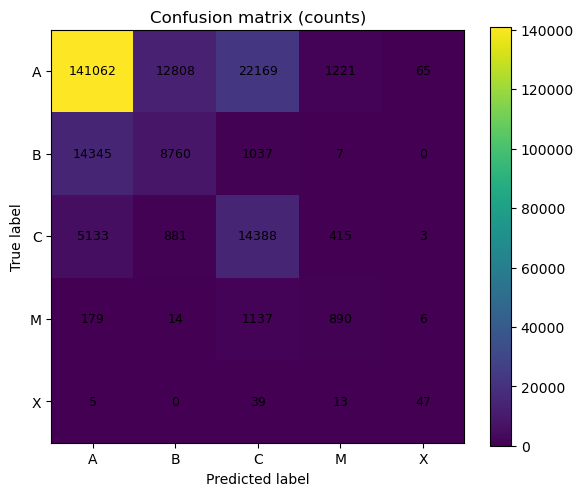

In [52]:
from sklearn.metrics import confusion_matrix

labels = ['A','B','C','M','X']
cm_CNN = confusion_matrix(all_true, all_preds)

print("Counts:")
print(pd.DataFrame(cm_CNN, index=labels, columns=labels))
title = "Confusion matrix (counts)"
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm_CNN)

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title(title)

# annotate cells
for i in range(len(labels)):
    for j in range(len(labels)):
        val = cm_CNN[i, j]
        if isinstance(val, (float, np.floating)):
            text = f"{val:.2f}"
        else:
            text = str(int(val))
        ax.text(j, i, text, ha="center", va="center", fontsize=9)

fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

In [35]:
from sklearn.metrics import classification_report, confusion_matrix

# Ground truth: ≥C
y_true_C = (all_true >= 2).astype(int)
y_pred_C = (all_preds >= 2).astype(int)

print("Binary ≥C classification report:")
print(classification_report(
    y_true_C,
    y_pred_C,
    target_names=["<C (A/B)", "≥C (C/M/X)"]
))

print("Confusion matrix (≥C):")
print(confusion_matrix(y_true_C, y_pred_C))

Binary ≥C classification report:
              precision    recall  f1-score   support

    <C (A/B)       0.97      0.88      0.92    201474
  ≥C (C/M/X)       0.41      0.73      0.52     23150

    accuracy                           0.86    224624
   macro avg       0.69      0.81      0.72    224624
weighted avg       0.91      0.86      0.88    224624

Confusion matrix (≥C):
[[176975  24499]
 [  6212  16938]]


In [36]:
# Ground truth: ≥M
y_true_M = (all_true >= 3).astype(int)
y_pred_M = (all_preds >= 3).astype(int)

print("Binary ≥M classification report:")
print(classification_report(
    y_true_M,
    y_pred_M,
    target_names=["<M (A/B/C)", "≥M (M/X)"]
))

print("Confusion matrix (≥M):")
print(confusion_matrix(y_true_M, y_pred_M))

Binary ≥M classification report:
              precision    recall  f1-score   support

  <M (A/B/C)       0.99      0.99      0.99    222294
    ≥M (M/X)       0.36      0.41      0.38      2330

    accuracy                           0.99    224624
   macro avg       0.68      0.70      0.69    224624
weighted avg       0.99      0.99      0.99    224624

Confusion matrix (≥M):
[[220583   1711]
 [  1374    956]]


In [37]:
class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(SeqDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(SeqDataset(X_val, y_val), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=0)
test_loader  = DataLoader(SeqDataset(X_test, y_test), batch_size=BATCH_SIZE*2, shuffle=False, num_workers=0)

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=1.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, logits, targets):
        ce = F.cross_entropy(logits, targets, weight=self.alpha, reduction='none')
        pt = torch.exp(-ce)
        return (((1 - pt) ** self.gamma) * ce).mean()

In [38]:
# RNN

In [39]:
class RNN(nn.Module):
    def __init__(self, hidden=64):
        super().__init__()
        self.rnn = nn.RNN(2, hidden, batch_first=True)
        self.fc = nn.Linear(hidden, 5)

    def forward(self, x):
        _, h = self.rnn(x)
        return self.fc(h[-1])

In [40]:
# LSTM

In [41]:
class LSTM(nn.Module):
    def __init__(self, hidden=96):
        super().__init__()
        self.lstm = nn.LSTM(2, hidden, batch_first=True)
        self.fc = nn.Linear(hidden, 5)

    def forward(self, x):
        _, (h, _) = self.lstm(x)
        return self.fc(h[-1])

In [42]:
# GRU

In [43]:
class GRU(nn.Module):
    def __init__(self, hidden=96):
        super().__init__()
        self.gru = nn.GRU(2, hidden, batch_first=True)
        self.fc = nn.Linear(hidden, 5)

    def forward(self, x):
        _, h = self.gru(x)
        return self.fc(h[-1])

In [63]:
def train_and_eval(model, name):
    model = model.to(device)
    criterion = FocalLoss(alpha=class_weights, gamma=1.0)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    for ep in range(1, EPOCHS+1):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb).argmax(1)
                correct += (preds == yb).sum().item()
                total += len(yb)

        print(f"{name} | Epoch {ep:02d} | Val acc: {correct/total:.3f}")

    # Test
    model.eval()
    all_p, all_t = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            out = model(xb)
            all_p.append(out.argmax(1).cpu().numpy())
            all_t.append(yb.numpy())

    all_p = np.concatenate(all_p)
    all_t = np.concatenate(all_t)
    CLASSES = ['A','B','C','M','X']
    report = classification_report(all_t, all_p, target_names=CLASSES)
    cm = confusion_matrix(all_t, all_p)

    print(f"\n{name} CLASSIFICATION REPORT\n", report)

    print(f"\nConfusion matrix for {name}:\n")
    print("Counts:")
    print(pd.DataFrame(cm, index=labels, columns=labels))
    title = "Confusion matrix (counts)"
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm)
    
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title(title)
    
    for i in range(len(labels)):
        for j in range(len(labels)):
            val = cm[i, j]
            if isinstance(val, (float, np.floating)):
                text = f"{val:.2f}"
            else:
                text = str(int(val))
            ax.text(j, i, text, ha="center", va="center", fontsize=9)
    
    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

    return all_t, all_p

RNN | Epoch 01 | Val acc: 0.680
RNN | Epoch 02 | Val acc: 0.639
RNN | Epoch 03 | Val acc: 0.593
RNN | Epoch 04 | Val acc: 0.674
RNN | Epoch 05 | Val acc: 0.721
RNN | Epoch 06 | Val acc: 0.690
RNN | Epoch 07 | Val acc: 0.654
RNN | Epoch 08 | Val acc: 0.648
RNN | Epoch 09 | Val acc: 0.619
RNN | Epoch 10 | Val acc: 0.701

RNN CLASSIFICATION REPORT
               precision    recall  f1-score   support

           A       0.85      0.79      0.81    177325
           B       0.27      0.11      0.15     24149
           C       0.31      0.71      0.43     20820
           M       0.21      0.25      0.23      2226
           X       0.07      0.07      0.07       104

    accuracy                           0.70    224624
   macro avg       0.34      0.38      0.34    224624
weighted avg       0.73      0.70      0.70    224624


Confusion matrix for RNN:

Counts:
        A     B      C     M   X
A  139338  6580  29694  1625  88
B   20151  2581   1408     9   0
C    5112   437  14834   436

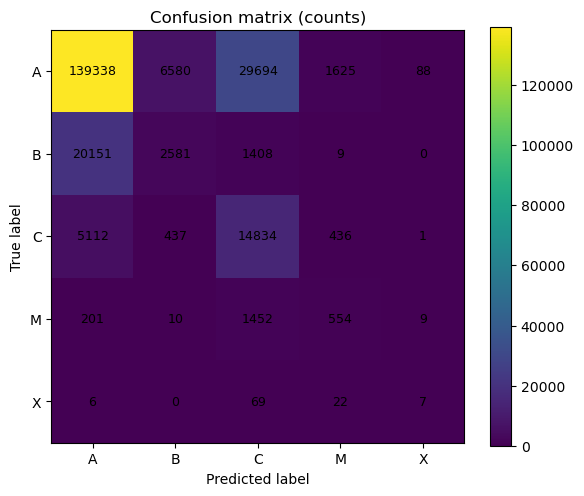

(array([0, 0, 2, ..., 0, 2, 0]), array([2, 2, 2, ..., 0, 0, 2]))

In [64]:
rnn = RNN(hidden=64)
train_and_eval(rnn, "RNN")

LSTM | Epoch 01 | Val acc: 0.760
LSTM | Epoch 02 | Val acc: 0.643
LSTM | Epoch 03 | Val acc: 0.687
LSTM | Epoch 04 | Val acc: 0.646
LSTM | Epoch 05 | Val acc: 0.669
LSTM | Epoch 06 | Val acc: 0.647
LSTM | Epoch 07 | Val acc: 0.694
LSTM | Epoch 08 | Val acc: 0.706
LSTM | Epoch 09 | Val acc: 0.692
LSTM | Epoch 10 | Val acc: 0.734

LSTM CLASSIFICATION REPORT
               precision    recall  f1-score   support

           A       0.87      0.81      0.84    177325
           B       0.35      0.36      0.35     24149
           C       0.38      0.62      0.47     20820
           M       0.27      0.24      0.25      2226
           X       0.14      0.37      0.21       104

    accuracy                           0.73    224624
   macro avg       0.40      0.48      0.42    224624
weighted avg       0.76      0.73      0.75    224624


Confusion matrix for LSTM:

Counts:
        A      B      C     M    X
A  142885  14581  18686  1040  133
B   14436   8589   1115     2    7
C    5860 

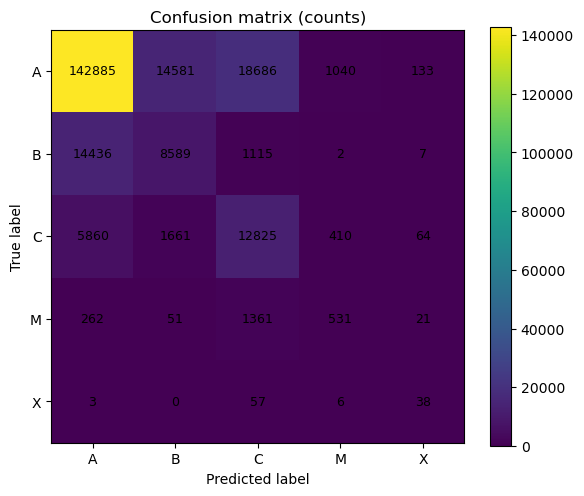

(array([0, 0, 2, ..., 0, 2, 0]), array([2, 2, 2, ..., 0, 0, 0]))

In [65]:
lstm = LSTM(hidden=96)
train_and_eval(lstm, "LSTM")

GRU | Epoch 01 | Val acc: 0.680
GRU | Epoch 02 | Val acc: 0.647
GRU | Epoch 03 | Val acc: 0.717
GRU | Epoch 04 | Val acc: 0.685
GRU | Epoch 05 | Val acc: 0.685
GRU | Epoch 06 | Val acc: 0.716
GRU | Epoch 07 | Val acc: 0.728
GRU | Epoch 08 | Val acc: 0.698
GRU | Epoch 09 | Val acc: 0.698
GRU | Epoch 10 | Val acc: 0.690

GRU CLASSIFICATION REPORT
               precision    recall  f1-score   support

           A       0.90      0.72      0.80    177325
           B       0.32      0.51      0.39     24149
           C       0.35      0.68      0.46     20820
           M       0.26      0.46      0.33      2226
           X       0.35      0.86      0.49       104

    accuracy                           0.69    224624
   macro avg       0.43      0.64      0.49    224624
weighted avg       0.78      0.69      0.72    224624


Confusion matrix for GRU:

Counts:
        A      B      C     M   X
A  127432  24157  23809  1829  98
B    9994  12213   1931     4   7
C    3559   1994  14155  

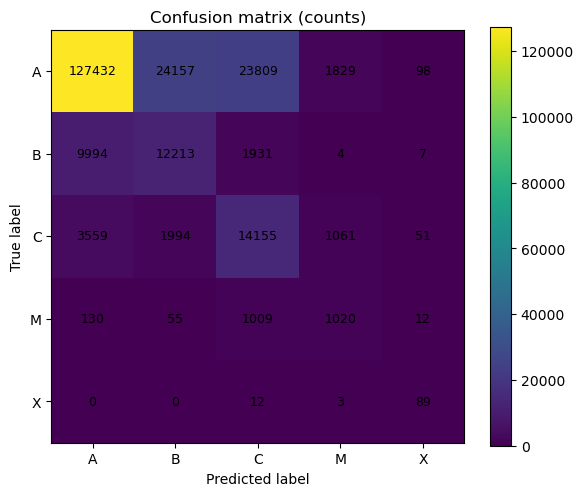

(array([0, 0, 2, ..., 0, 2, 0]), array([2, 2, 2, ..., 0, 2, 2]))

In [66]:
gru = GRU(hidden=69)
train_and_eval(gru, "GRU")